In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [16]:
#import librarires
!pip install keras-tuner --upgrade
import kerastuner as kt
from tensorflow import keras
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter as hp
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle
import imageio
import cv2
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
# import the module
from keras.models import Model

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from keras_resnet.models import ResNet50
from keras.applications.mobilenet import MobileNet
#from tensorflow.keras.applications.vgg19 import preprocess_input

Defaulting to user installation because normal site-packages is not writeable


ModuleNotFoundError: No module named 'keras_resnet'

In [3]:
# changing dir and loading images in the folder
filepath = "C:\\Users\\CyberOps\\agubalanceface"
os.chdir(filepath)

onlyfiles = os.listdir()
len(onlyfiles)

6840

In [4]:
shuffle(onlyfiles)
age = [i.split('_')[0] for i in onlyfiles]


In [6]:
print(len(age))

6840


In [5]:
X_data =[]
for file in onlyfiles:
  if(file !="model.png"):
      img=imageio.imread(file,pilmode="RGB")
      img =cv2.resize(img, (120,120))
      X_data.append(img)

C:\Users\CyberOps\AppData\Local\Temp\ipykernel_6076\3754214948.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imageio.imread(file,pilmode="RGB")


In [7]:
X = np.squeeze(X_data)
X.shape


(6840, 120, 120, 3)

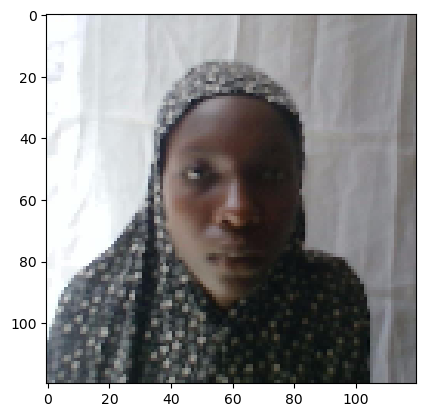

In [8]:
plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [9]:
# normalize data
X = X.astype('float32')
X /= 255


In [10]:
ages = pd.Series(age, name='Age').astype(np.int)

C:\Users\CyberOps\AppData\Local\Temp\ipykernel_6076\600970202.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ages = pd.Series(age, name='Age').astype(np.int)


In [11]:
ages.dtype

dtype('int32')

In [12]:
X.shape

(6840, 120, 120, 3)

In [13]:
train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train_reg, y_test_reg  = train_test_split(X, ages, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test,y_val_reg, y_test_reg= train_test_split(x_test,  y_test_reg,test_size=test_ratio/(test_ratio + validation_ratio))

print("Training Image Size", x_train.shape," Validation Image Size", x_val.shape, "Testing Image Size ",x_test.shape)
print("Training Label Size",y_train_reg.shape, "validation Label Size",y_val_reg.shape, "Testing Image Size",y_test_reg.shape)


Training Image Size (4787, 120, 120, 3)  Validation Image Size (1368, 120, 120, 3) Testing Image Size  (685, 120, 120, 3)
Training Label Size (4787,) validation Label Size (1368,) Testing Image Size (685,)


In [16]:
shape=x_train[0]

In [17]:
ages.shape

(6840,)

In [18]:
## Loading VGG16 model
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
vgg16_model.trainable = False ## Not trainable weights

In [19]:
mobilenet_model = MobileNet(input_shape=x_train[0].shape, 
                                 include_top = False, 
                                 weights ="imagenet" )
mobilenet_model .trainable = False ## Not trainable weights

In [20]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 60, 60, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 60, 60, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 60, 60, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 60, 60, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 60, 60, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 7, 7, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 7, 7, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 7, 7, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 7, 7, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 7, 7, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 7, 7, 512)         262144    
                                                                 
 conv_pw_9

In [21]:
# layers of vgg16
mobilenet_layer_list = mobilenet_model.layers
for i in mobilenet_layer_list:
    print(i)

In [19]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 60, 60, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 60, 60, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 60, 60, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 60, 60, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 60, 60, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 7, 7, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 7, 7, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 7, 7, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 7, 7, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 7, 7, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 7, 7, 512)         262144    
                                                                 
 conv_pw_9

In [22]:
# Freeze four convolution blocks
for layer in mobilenet_model.layers[:10]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(mobilenet_model.layers):
    print(i, layer.name, layer.trainable)


0 input_2 False
1 conv1 False
2 conv1_bn False
3 conv1_relu False
4 conv_dw_1 False
5 conv_dw_1_bn False
6 conv_dw_1_relu False
7 conv_pw_1 False
8 conv_pw_1_bn False
9 conv_pw_1_relu False
10 conv_pad_2 False
11 conv_dw_2 False
12 conv_dw_2_bn False
13 conv_dw_2_relu False
14 conv_pw_2 False
15 conv_pw_2_bn False
16 conv_pw_2_relu False
17 conv_dw_3 False
18 conv_dw_3_bn False
19 conv_dw_3_relu False
20 conv_pw_3 False
21 conv_pw_3_bn False
22 conv_pw_3_relu False
23 conv_pad_4 False
24 conv_dw_4 False
25 conv_dw_4_bn False
26 conv_dw_4_relu False
27 conv_pw_4 False
28 conv_pw_4_bn False
29 conv_pw_4_relu False
30 conv_dw_5 False
31 conv_dw_5_bn False
32 conv_dw_5_relu False
33 conv_pw_5 False
34 conv_pw_5_bn False
35 conv_pw_5_relu False
36 conv_pad_6 False
37 conv_dw_6 False
38 conv_dw_6_bn False
39 conv_dw_6_relu False
40 conv_pw_6 False
41 conv_pw_6_bn False
42 conv_pw_6_relu False
43 conv_dw_7 False
44 conv_dw_7_bn False
45 conv_dw_7_relu False
46 conv_pw_7 False
47 conv_pw_7_bn 

In [23]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 60, 60, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 60, 60, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 60, 60, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 60, 60, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 60, 60, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 7, 7, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 7, 7, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 7, 7, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 7, 7, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 7, 7, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 7, 7, 512)         262144    
                                                                 
 conv_pw_9

In [30]:
from tensorflow.keras import layers, models


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')

dense_layer_2 = layers.Dense(64, activation='relu')

dense_layer_3 = layers.Dense(128, activation='relu')

dense_layer_4 = layers.Dense(128, activation='relu')

prediction_layer = layers.Dense(1, activation='linear')


vgg16_net_model = models.Sequential([
 vgg16_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    dense_layer_4,
  prediction_layer
])

In [31]:
vgg16_net_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)



In [32]:
input_shape = X.shape  
vgg16_net_model.build(input_shape) 
vgg16_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                294976    
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 1)                

In [33]:
vgg16_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                294976    
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 1)                

In [47]:

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model_historyA=vgg16_net_model.fit(x_train,y_train_reg, batch_size=32,epochs=20,validation_data=(x_val, y_val_reg),callbacks=[early_stopping])




Epoch 1/20
150/150 [==============================] - 280s 2s/step - loss: 8.1335 - mae: 2.2454 - val_loss: 5.6824 - val_mae: 1.8269
Epoch 2/20
150/150 [==============================] - 344s 2s/step - loss: 4.8785 - mae: 1.6841 - val_loss: 3.9178 - val_mae: 1.4657
Epoch 3/20
150/150 [==============================] - 378s 3s/step - loss: 3.0174 - mae: 1.3006 - val_loss: 3.0424 - val_mae: 1.2647
Epoch 4/20
150/150 [==============================] - 374s 2s/step - loss: 2.1047 - mae: 1.0846 - val_loss: 3.0932 - val_mae: 1.2766
Epoch 5/20
150/150 [==============================] - 381s 3s/step - loss: 1.5688 - mae: 0.9269 - val_loss: 2.3283 - val_mae: 1.0287
Epoch 6/20
150/150 [==============================] - 387s 3s/step - loss: 1.3899 - mae: 0.8782 - val_loss: 2.3707 - val_mae: 1.0560
Epoch 7/20
150/150 [==============================] - 376s 3s/step - loss: 1.2771 - mae: 0.8433 - val_loss: 1.9806 - val_mae: 0.9031
Epoch 8/20
150/150 [==============================] - 379s 3s/step - 

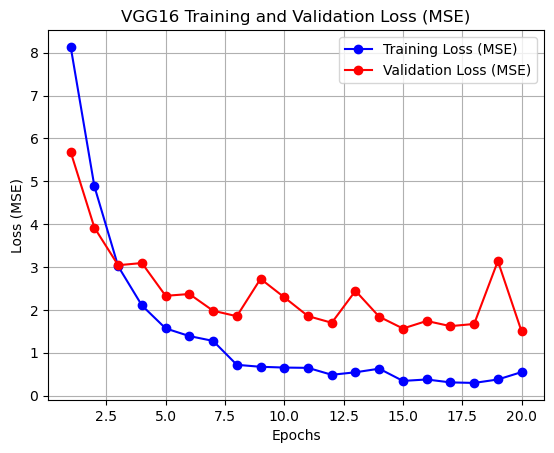

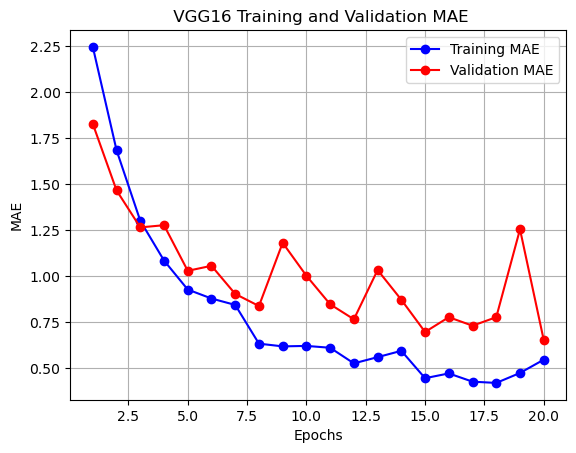

In [8]:
import matplotlib.pyplot as plt

# Training history data
history = {
    'loss': [8.1335, 4.8785, 3.0174, 2.1047, 1.5688, 1.3899, 1.2771, 0.7196, 0.6734, 0.6555, 0.6483, 0.4868, 0.5454, 0.6290, 0.3440, 0.3775, 0.3094, 0.2972, 0.3774, 0.5501],
    'val_loss': [5.6824, 3.9178, 3.0424, 3.0932, 2.3283, 2.3707, 1.9806, 1.8531, 2.7250, 2.2937, 1.8555, 1.7001, 2.4447, 1.8411, 1.5660, 1.7422, 1.6216, 1.6721, 3.1399, 1.4966],
    'mae': [2.2454, 1.6841, 1.3006, 1.0846, 0.9269, 0.8782, 0.8433, 0.6329, 0.6181, 0.6206, 0.6106, 0.5258, 0.5596, 0.5940, 0.4452, 0.4711, 0.4263, 0.4195, 0.4736, 0.5458],
    'val_mae': [1.8269, 1.4657, 1.2647, 1.2766, 1.0287, 1.0560, 0.9031, 0.8374, 1.1809, 1.0018, 0.8468, 0.7653, 1.0330, 0.8714, 0.6964, 0.7767, 0.7304, 0.7767, 1.2543, 0.6527]
}

epochs = range(1, len(history['loss']) + 1)

# Plotting loss (MSE)
plt.plot(epochs, history['loss'], 'bo-', label='Training Loss (MSE)')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss (MSE)')
plt.title('VGG16 Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting MAE
plt.plot(epochs, history['mae'], 'bo-', label='Training MAE')
plt.plot(epochs, history['val_mae'], 'ro-', label='Validation MAE')
plt.title(' VGG16 Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
true_ages = y_test_reg
predicted_ages = np.squeeze(vgg16_net_model.predict(x_test))


# Calculation of Mean Squared Error (MSE)
mse= mean_squared_error(true_ages ,predicted_ages)

print ("The MSE",mse)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
mae=mean_absolute_error(true_ages ,predicted_ages)
print ("The MAE",mae)


rmse = np.sqrt(mse)

print ("this is the rmse",rmse )
true_ages = y_test_reg


r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

22/22 [==============================] - 42s 2s/step
The MSE 1.8646988149260157
The MAE 0.6905187258755203
this is the rmse 1.3655397522320674
Test R^2 Score: 0.92536


In [49]:
vgg16_net_model.save("../model/Vgg_model.h5", include_optimizer=True)

In [50]:
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
vgg19_model.trainable = False ## Not trainable weights

In [51]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [52]:


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')

dense_layer_2 = layers.Dense(64, activation='relu')

dense_layer_3 = layers.Dense(128, activation='relu')

dense_layer_4 = layers.Dense(128, activation='relu')

prediction_layer = layers.Dense(1, activation='linear')


vgg19_net_model = models.Sequential([
  vgg19_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    dense_layer_4,
  prediction_layer
])


In [53]:
vgg19_net_model.summary()

vgg19_net_model.compile(optimizer="adam", loss="mse", metrics="mae")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 4608)              0         
                                                                 
 dense_28 (Dense)            (None, 64)                294976    
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 128)               8320      
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 1)                

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model_historyB=vgg19_net_model.fit(x_train,y_train_reg, batch_size=32,epochs=20,validation_data=(x_val, y_val_reg),callbacks=[early_stopping])


Epoch 1/20
150/150 [==============================] - 472s 3s/step - loss: 34.8489 - mae: 4.4704 - val_loss: 14.7989 - val_mae: 3.1507
Epoch 2/20
150/150 [==============================] - 489s 3s/step - loss: 11.9411 - mae: 2.7926 - val_loss: 8.7734 - val_mae: 2.3238
Epoch 3/20
150/150 [==============================] - 466s 3s/step - loss: 7.3162 - mae: 2.1012 - val_loss: 5.6621 - val_mae: 1.8104
Epoch 4/20
150/150 [==============================] - 468s 3s/step - loss: 4.8297 - mae: 1.6720 - val_loss: 10.1456 - val_mae: 2.6852
Epoch 5/20
150/150 [==============================] - 479s 3s/step - loss: 3.8172 - mae: 1.4829 - val_loss: 3.6512 - val_mae: 1.4442
Epoch 6/20
150/150 [==============================] - 473s 3s/step - loss: 2.5076 - mae: 1.1908 - val_loss: 3.7341 - val_mae: 1.4793
Epoch 7/20
150/150 [==============================] - 477s 3s/step - loss: 2.2548 - mae: 1.1345 - val_loss: 2.3223 - val_mae: 1.0971
Epoch 8/20
150/150 [==============================] - 470s 3s/ste

In [55]:
true_ages = y_test_reg
predicted_ages = np.squeeze(vgg19_net_model.predict(x_test))


# Calculation of Mean Squared Error (MSE)
mse= mean_squared_error(true_ages ,predicted_ages)

print ("The MSE",mse)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
mae=mean_absolute_error(true_ages ,predicted_ages)
print ("The MAE",mae)


rmse = np.sqrt(mse)

print ("this is the rmse",rmse )
true_ages = y_test_reg


r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

22/22 [==============================] - 50s 2s/step
The MSE 2.5781488362440457
The MAE 1.0830116202361393
this is the rmse 1.6056614949123136
Test R^2 Score: 0.89680


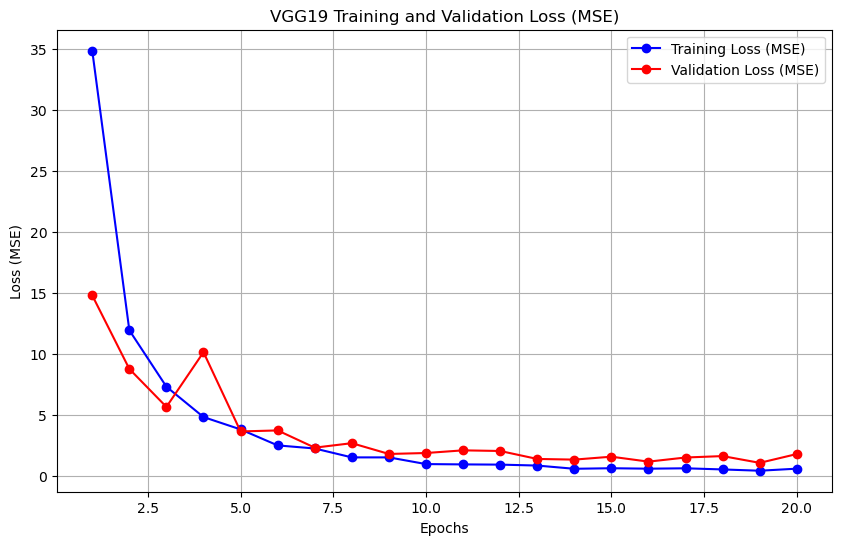

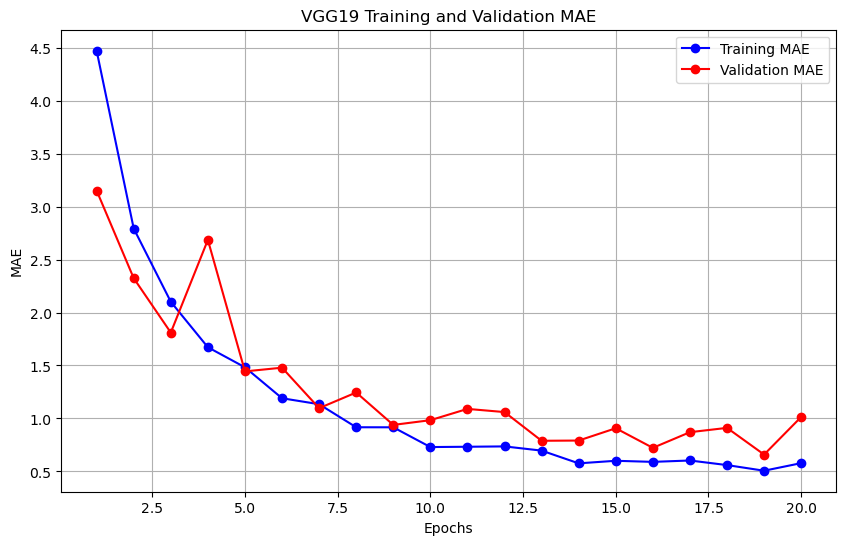

In [7]:
import matplotlib.pyplot as plt

# Training history data
epochs = range(1, 21)  # Number of epochs (1 to 20)

loss = [34.8489, 11.9411, 7.3162, 4.8297, 3.8172, 2.5076, 2.2548, 1.5249, 1.5250, 0.9767, 
        0.9504, 0.9326, 0.8557, 0.5917, 0.6365, 0.5995, 0.6312, 0.5375, 0.4325, 0.6009]

val_loss = [14.7989, 8.7734, 5.6621, 10.1456, 3.6512, 3.7341, 2.3223, 2.6897, 1.8061, 1.8834, 
            2.1021, 2.0497, 1.3976, 1.3429, 1.5822, 1.1769, 1.5153, 1.6320, 1.0776, 1.7996]

mae = [4.4704, 2.7926, 2.1012, 1.6720, 1.4829, 1.1908, 1.1345, 0.9171, 0.9166, 0.7302, 
       0.7331, 0.7364, 0.6967, 0.5765, 0.6007, 0.5904, 0.6034, 0.5601, 0.5069, 0.5785]

val_mae = [3.1507, 2.3238, 1.8104, 2.6852, 1.4442, 1.4793, 1.0971, 1.2452, 0.9392, 0.9838, 
           1.0903, 1.0603, 0.7895, 0.7916, 0.9077, 0.7227, 0.8706, 0.9112, 0.6594, 1.0143]

# Plotting Loss (MSE)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss (MSE)')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss (MSE)')
plt.title('VGG19 Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting MAE
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('VGG19 Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
vgg19_net_model.save("../model/vgg19_model.h5", include_optimizer=True)

In [18]:
resnet50model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False,  input_shape=x_train[0].shape)
for layer in resnet50model.layers:
  layer.trainable = False




In [19]:
resnet50model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 126, 126, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 60, 60, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 60, 60, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 30, 30, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 30, 30, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 30, 30, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 30, 30, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 15, 15, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 15, 15, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 15, 15, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 15, 15, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [20]:
from tensorflow.keras import layers, models




flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')

dense_layer_2 = layers.Dense(64, activation='relu')

dense_layer_3 = layers.Dense(128, activation='relu')

dense_layer_4 = layers.Dense(128, activation='relu')

prediction_layer = layers.Dense(1, activation='linear')


ResNet50_model = models.Sequential([
    resnet50model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    dense_layer_4,
  prediction_layer
])

In [21]:
ResNet50_model.summary()
ResNet50_model.compile(optimizer="adam", loss="mse", metrics="mae")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 1

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model_historyC=ResNet50_model.fit(x_train,y_train_reg, batch_size=32,epochs=20,validation_data=(x_test, y_test_reg),callbacks=[early_stopping])


Epoch 1/20
150/150 [==============================] - 83s 542ms/step - loss: 46.5832 - mae: 5.3403 - val_loss: 25.5237 - val_mae: 4.3519
Epoch 2/20
150/150 [==============================] - 84s 559ms/step - loss: 24.6366 - mae: 4.2510 - val_loss: 23.2671 - val_mae: 4.1019
Epoch 3/20
150/150 [==============================] - 88s 585ms/step - loss: 24.3841 - mae: 4.1452 - val_loss: 21.9101 - val_mae: 3.9442
Epoch 4/20
150/150 [==============================] - 91s 606ms/step - loss: 23.0635 - mae: 4.0031 - val_loss: 22.3754 - val_mae: 3.9002
Epoch 5/20
150/150 [==============================] - 97s 646ms/step - loss: 20.8841 - mae: 3.7788 - val_loss: 19.8229 - val_mae: 3.7121
Epoch 6/20
150/150 [==============================] - 112s 746ms/step - loss: 22.0339 - mae: 3.8637 - val_loss: 20.5796 - val_mae: 3.7364
Epoch 7/20
150/150 [==============================] - 122s 812ms/step - loss: 20.3403 - mae: 3.7119 - val_loss: 19.1125 - val_mae: 3.6519
Epoch 8/20
150/150 [===================

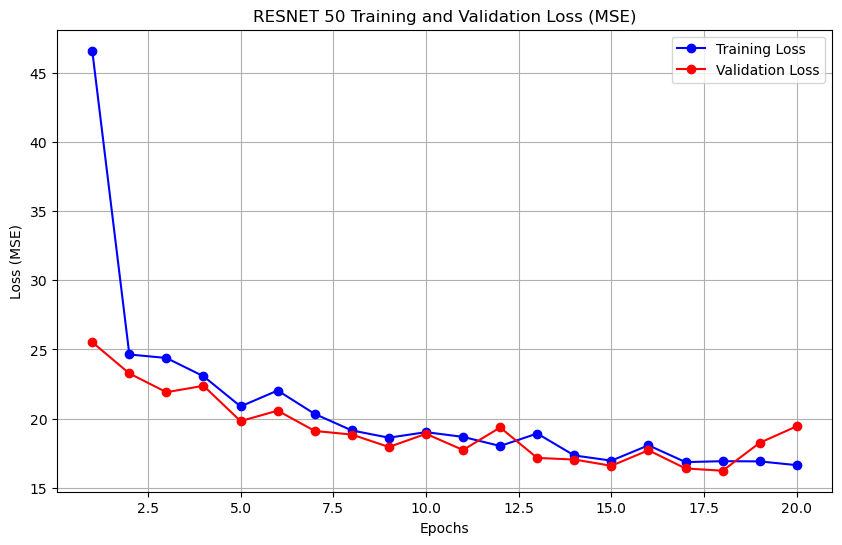

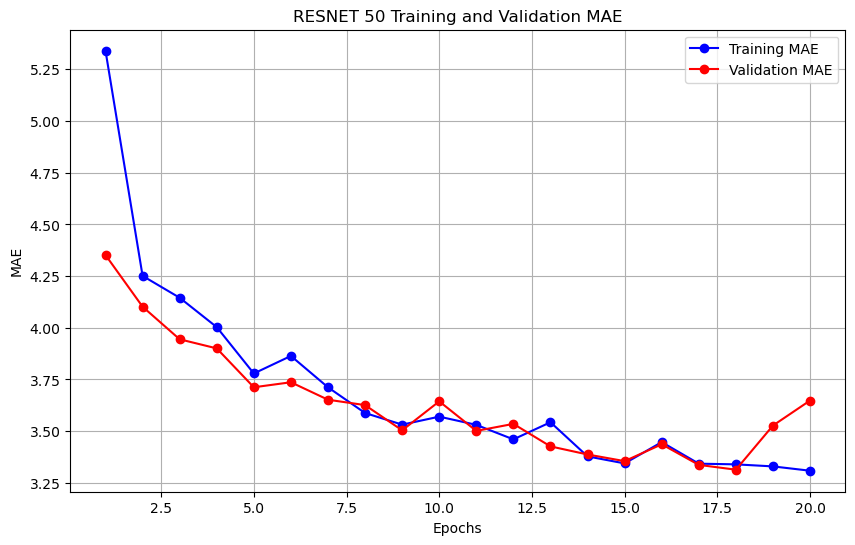

In [9]:
import matplotlib.pyplot as plt

# Training history data
epochs = range(1, 21)  # Number of epochs (1 to 20)

# Loss (MSE) and MAE values
train_loss = [46.5832, 24.6366, 24.3841, 23.0635, 20.8841, 22.0339, 20.3403, 19.1497, 18.6253, 19.0262,
              18.6829, 18.0268, 18.9257, 17.3417, 16.9669, 18.0748, 16.8611, 16.9288, 16.9128, 16.6415]

val_loss = [25.5237, 23.2671, 21.9101, 22.3754, 19.8229, 20.5796, 19.1125, 18.8521, 17.9533, 18.9058,
            17.7365, 19.3640, 17.1627, 17.0479, 16.5947, 17.7190, 16.4009, 16.2389, 18.2548, 19.4519]

train_mae = [5.3403, 4.2510, 4.1452, 4.0031, 3.7788, 3.8637, 3.7119, 3.5876, 3.5313, 3.5700,
             3.5303, 3.4601, 3.5429, 3.3777, 3.3438, 3.4468, 3.3425, 3.3392, 3.3293, 3.3084]

val_mae = [4.3519, 4.1019, 3.9442, 3.9002, 3.7121, 3.7364, 3.6519, 3.6258, 3.5038, 3.6440,
           3.5010, 3.5350, 3.4261, 3.3869, 3.3548, 3.4363, 3.3366, 3.3134, 3.5270, 3.6480]

# Plotting Loss (MSE)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('RESNET 50 Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting MAE
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('RESNET 50 Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
true_ages = y_test_reg
predicted_ages = np.squeeze(ResNet50_model.predict(x_test))


# Calculation of Mean Squared Error (MSE)
mse= mean_squared_error(true_ages ,predicted_ages)

print ("The MSE",mse)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
mae=mean_absolute_error(true_ages ,predicted_ages)
print ("The MAE",mae)


rmse = np.sqrt(mse)

print ("this is the rmse",rmse )
true_ages = y_test_reg


r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

22/22 [==============================] - 18s 767ms/step
The MSE 19.4519013786054
The MAE 3.6480497179240206
this is the rmse 4.410430974247913
Test R^2 Score: 0.27612


In [26]:
ResNet50_model.save("../model/resnet50_model.h5", include_optimizer=True)

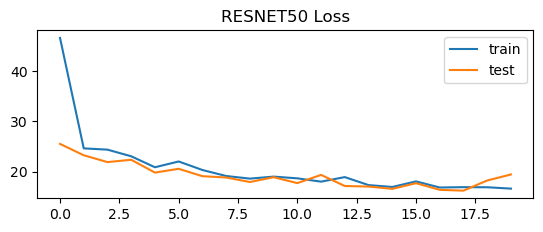

In [27]:
# plot loss during training
plt.subplot(211)
plt.title('RESNET50 Loss')
plt.plot(model_historyC.history['loss'], label='train')
plt.plot(model_historyC.history['val_loss'], label='test')
plt.legend()


In [ ]:
mobilenet_model.summary()

In [38]:
from tensorflow.keras import layers, models




flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')

dense_layer_2 = layers.Dense(64, activation='relu')

dense_layer_3 = layers.Dense(128, activation='relu')

dense_layer_4 = layers.Dense(128, activation='relu')

prediction_layer = layers.Dense(1, activation='linear')


mobilNet_model = models.Sequential([
    mobilenet_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    dense_layer_4,
  prediction_layer
])

In [42]:
mobilNet_model.compile(optimizer="adam", loss="mse", metrics="mae")


In [39]:
mobilNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 9216)              0         
                                                                 
 dense_23 (Dense)            (None, 64)                589888    
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 128)               8320      
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                      

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model_historyA=mobilNet_model.fit(x_train,y_train_reg, batch_size=32,epochs=20,validation_data=(x_val, y_val_reg),callbacks=[early_stopping])


Epoch 1/20
150/150 [==============================] - 33s 208ms/step - loss: 20.6673 - mae: 3.1869 - val_loss: 7.1285 - val_mae: 2.0853
Epoch 2/20
150/150 [==============================] - 38s 256ms/step - loss: 3.7786 - mae: 1.4744 - val_loss: 4.3340 - val_mae: 1.6466
Epoch 3/20
150/150 [==============================] - 40s 266ms/step - loss: 1.7274 - mae: 0.9948 - val_loss: 2.0354 - val_mae: 1.0264
Epoch 4/20
150/150 [==============================] - 39s 260ms/step - loss: 1.0907 - mae: 0.7975 - val_loss: 1.5740 - val_mae: 0.8839
Epoch 5/20
150/150 [==============================] - 39s 259ms/step - loss: 0.8029 - mae: 0.6760 - val_loss: 1.7391 - val_mae: 0.9598
Epoch 6/20
150/150 [==============================] - 38s 251ms/step - loss: 0.8037 - mae: 0.6997 - val_loss: 1.5934 - val_mae: 0.8846
Epoch 7/20
150/150 [==============================] - 38s 253ms/step - loss: 0.5567 - mae: 0.5712 - val_loss: 1.3756 - val_mae: 0.8167
Epoch 8/20
150/150 [==============================] - 

In [46]:
true_ages = y_test_reg
predicted_ages = np.squeeze(mobilNet_model.predict(x_test))


# Calculation of Mean Squared Error (MSE)
mse= mean_squared_error(true_ages ,predicted_ages)

print ("The MSE",mse)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
mae=mean_absolute_error(true_ages ,predicted_ages)
print ("The MAE",mae)


rmse = np.sqrt(mse)

print ("this is the rmse",rmse )
true_ages = y_test_reg


r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

22/22 [==============================] - 2s 109ms/step
The MSE 1.4405513267312116
The MAE 0.7081948704963182
this is the rmse 1.200229697487615
Test R^2 Score: 0.94234


In [25]:
import matplotlib.pyplot as plt

# Define epochs (1 to 20)
epochs = range(1, 20)

# Define training and validation loss values
train_loss = [20.6673, 3.7786, 1.7274, 1.0907, 0.8029, 0.8037, 0.5567, 0.4940, 0.5825, 0.6703,
              0.6988, 0.2852, 0.3400, 0.2969, 0.4728, 0.2800, 0.4760, 0.3710]

val_loss = [7.1285, 4.3340, 2.0354, 1.5740, 1.7391, 1.5934, 1.3756, 1.5161, 1.4174, 1.3767,
            1.0954, 1.0926, 1.0668, 1.1852, 1.1027, 1.3634, 1.1321, 1.4121]






ValueError: x and y must have same first dimension, but have shapes (19,) and (18,)

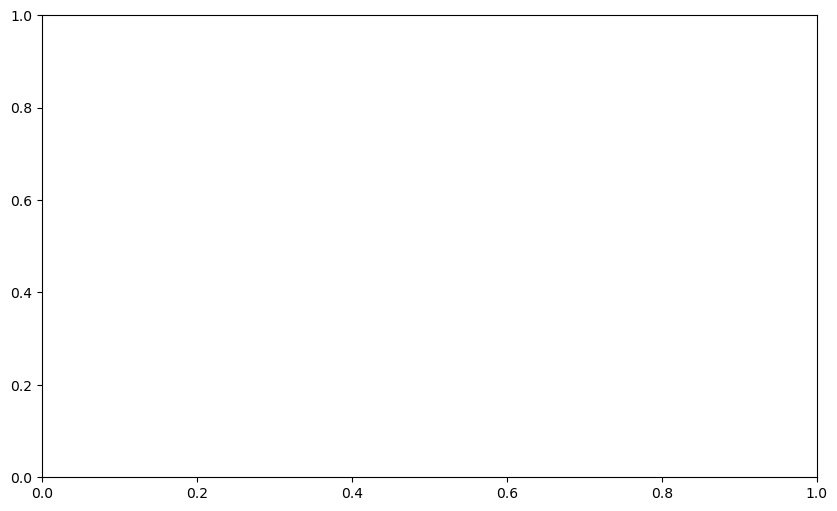

In [26]:




# Plotting training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (16,) and (18,)

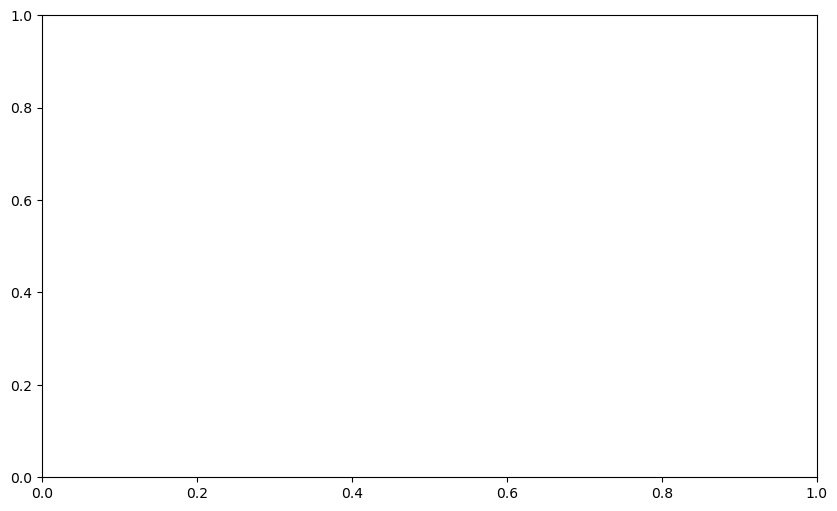

In [23]:

# Define training and validation MAE values
train_mae = [3.1869, 1.4744, 0.9948, 0.7975, 0.6760, 0.6997, 0.5712, 0.5402, 0.5816, 0.6270,
             0.6403, 0.4032, 0.4482, 0.4209, 0.5327, 0.4126, 0.5392, 0.4654]

val_mae = [2.0853, 1.6466, 1.0264, 0.8839, 0.9598, 0.8846, 0.8167, 0.8587, 0.8308, 0.8044,
           0.6834, 0.6752, 0.6732, 0.7235, 0.6996, 0.8597, 0.7266, 0.8611]
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
len(val_loss)

18